In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

In [3]:
# allow all columns to display
pd.set_option('display.max_columns', None)

In [4]:
#set seaborn plotting aesthetics
sns.set(style='whitegrid')
sns.set_context('notebook')
palette = sns.color_palette("colorblind")

In [7]:
# upload the outreach survey
outreach = pd.read_csv('./Data/ARISE - outreach.csv')

### Set up code for analysis

In [9]:
def strip_string(text):
    text = text.strip(',')
    text = text.strip()
    return text

In [10]:
def return_num(text):
    zip_list = re.findall('[0-9]+', text)
    return zip_list

In [11]:
def return_digits(text):
    text = re.findall(r'\d+', text)
    text = ''.join(text)
    return text


In [12]:
def make_five(text):
    if len(text) == 4:
        return '0'+text
    elif len(text) == 3:
        return '00'+text
    else:
        return text

### Which communities have been adding their outreach data?

In [13]:
outreach.community.unique()

array(['Arise for Will County', 'HEART', nan,
       'Community Unit School District 300', 'Engaging Alton for Equity',
       'Junior Media LLC', 'Juntos',
       'East Central Illinois Rural Healthcare Consortium',
       'Islamic Alliance to Advance Health Equity in Lake County (IHEAL)',
       'Immigrant Cooperative', 'Effingham Health Committee',
       'Rainbow Cafe',
       'Zeta Phi Beta Sorority Inc, Kappa Sigma Zeta Chapter',
       'YMCA of Metropolitan Chicago', 'ARISE Kankakee',
       'Quincy ARISE Coalition', 'Coordinated Care Alliance',
       'Clay County Health 4 Generations Coalition',
       'Lake County’s Black and Brown Coalition for Health Equity'],
      dtype=object)

#### Dataframe for community zipcodes

For this analysis, we want to analyze the Social Deprication Index for the zipcodes of the locations in which communities have focused their work. As part of this grant, communities aim to focus their outreach in areas that experience the greatest level of health inqeuity. 

The Social Deprivation Index (SDI) quantifies levels of disadvantage across small areas, evaluate their associations with health outcomes, and address health inequities. This measure of social deprivation, in combination with other indicators, has potential application in identifying areas that need additional health care resources.

In [68]:
# create a new dataframe with the community and zipcodes

location = pd.DataFrame()

location['community'] = outreach['community']

location['zipcode'] = outreach['outreach_zipcode']

# Communities entered multiple zipcodes into one column  in consistent form (some seperated by commas, other
# by space, etc) 
# the function below will extract the zipcodes and place them into a list
# this will make working with zipcodes a lot easier

location['zip_list'] = location['zipcode'].apply(lambda x: return_num(x) if(np.all(pd.notnull(x))) else x)

In [70]:
# only keep rows that have provided zipcodes
location.dropna(subset='zip_list', inplace=True)

### Extract all zips and corresponding community/grantee, merge with SDI dataset by zipcode

Grantees have done extensive amount of outreach. Outreach events/efforts many times reached multiple zipcodes. We therefore have multiple zipcodes in one cell, which makes it difficult to merge this data to another dataset by 'zipcode'. We will extract the zipcodes and make a tidy dataset, allowing us to merge this dataset with another. 

We will be merging with the SDI dataset which contains an SDI index per ZCTA (which we will be mapping to zipcodes) to analyze the SDI score of the area in which each outreach event took place. This way, we can analyze whether grantees have concentrated their efforts in communities that are most vulnerable and suffer heath inequities.

In [109]:
zips = []
community = []

In [110]:
ind = 0
for i in location['zip_list']:
    reps = len(i)
    zips.extend(i)
    community_name = location.iloc[ind][0]
    community += ([community_name] * reps)
    ind +=1
    

In [111]:
zips_communities = pd.DataFrame(
    {'community': community,
     'zip': zips}
)

### ZCTA Crosswalk

SDI dataset has scores for all US ZCTAs. We will merge a dataset that maps Zipcodes to ZCTAs to our outreach zipcode dataset. Afterwards, we will merge the outreach zipcodes dataset to the SDI scores. 

In [134]:
zip_zcta = pd.read_excel('Data/ZIPCodetoZCTACrosswalk2021.xlsx',
                         converters={'ZIP_CODE':str, 'ZCTA':str})

zcta_sdi = pd.read_csv('Data/zcta_SDI.csv')

zcta_sdi['ZCTA5_FIPS'] = zcta_sdi['ZCTA5_FIPS'].astype('str')

zcta_sdi['ZCTA5_FIPS'] = zcta_sdi['ZCTA5_FIPS'].apply(lambda x: make_five(x) if(np.all(pd.notnull(x))) else x)

#### Merge the zips to the zctas

In [135]:
zips_outreach = pd.merge(zips_communities, zip_zcta, left_on='zip', right_on='ZIP_CODE').drop(columns=['ZIP_TYPE','zip_join_type'])

#### Merge the zctas to SDIs

In [136]:
zips_outreach = pd.merge(zips_outreach, zcta_sdi, left_on='ZCTA', right_on='ZCTA5_FIPS', how='left')

### Make visuals

We will do a box plot to look at the distribution of SDI scores across Arise grantees and across all of ARISE. SDI scores range from 0 - 100, the higher the score, the most social deprivation is experienced by the area. An SDI score of 50+ indicates that the zipcode is in a underserved area.  

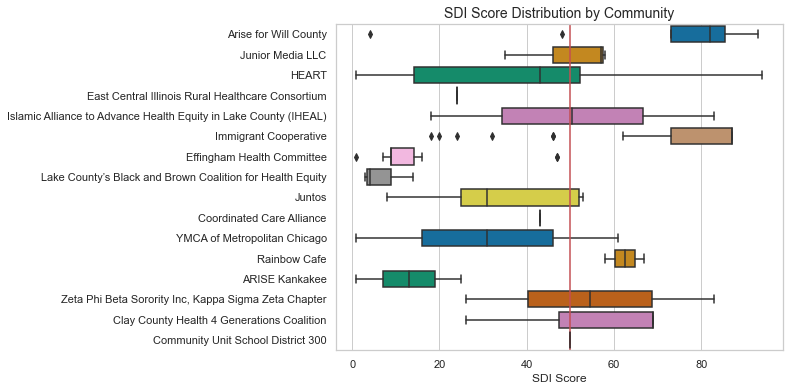

In [152]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=zips_outreach, x='SDI_score', y='community', palette=palette)
plt.axvline(x=50, color='r')
plt.xlabel('SDI Score',
          fontdict={'size':12})
plt.ylabel('')
plt.title('SDI Score Distribution by Community', fontdict={'size':14});
plt.savefig('./Figures/SDI_outreach_zips', bbox_inches='tight');

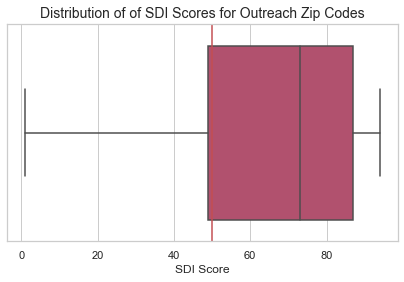

In [142]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=zips_outreach, x='SDI_score', palette='flare')
plt.axvline(x=50, color='r')
plt.xlabel('SDI Score',
          fontdict={'size':12})
plt.title('Distribution of of SDI Scores for Outreach Zip Codes',
         fontdict={'size':14});
plt.savefig('./Figures/SVI distribution of outreach zipcodes');

In [143]:
zips_outreach['SDI_score'].describe()

count    175.000000
mean      65.234286
std       27.811495
min        1.000000
25%       49.000000
50%       73.000000
75%       87.000000
max       94.000000
Name: SDI_score, dtype: float64

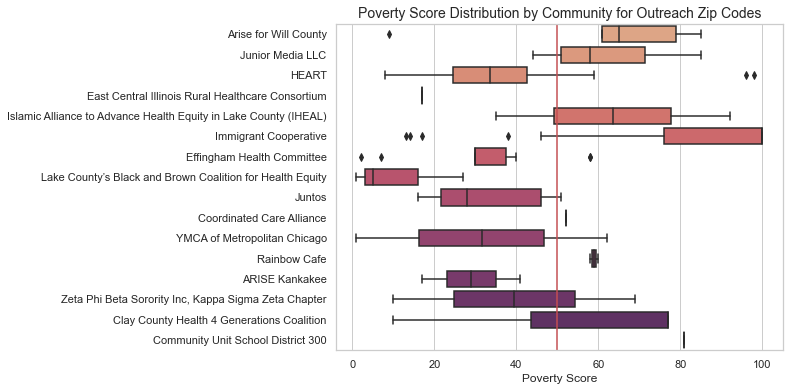

In [144]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=zips_outreach, x='PovertyLT100_FPL_score', y='community', palette='flare')
plt.axvline(x=50, color='r')
plt.xlabel('Poverty Score',
          fontdict={'size':12})
# plt.ylabel('Partner',
#           fontdict={'size':12})
plt.ylabel('')

plt.title('Poverty Score Distribution by Community for Outreach Zip Codes', fontdict={'size':14});
plt.savefig('./Figures/Outreach SDI',bbox_inches='tight');

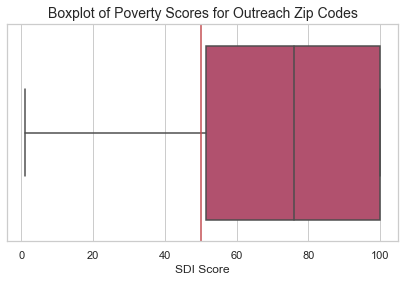

In [153]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=zips_outreach, x='PovertyLT100_FPL_score', palette='flare')
plt.axvline(x=50, color='r')
plt.xlabel('SDI Score',
          fontdict={'size':12})
plt.title('Boxplot of Poverty Scores for Outreach Zip Codes',
         fontdict={'size':14});
#plt.savefig('./Figures/SVI distribution of outreach zipcodes');